In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch. optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
import pickle
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import random
import numpy as np
import imageio


In [2]:
resnet = models.resnet18(weights='DEFAULT')
resnet_half = torch.nn.Sequential(*(list(resnet.children())[:7]))

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_size = 12544
        self.encoder = nn.Sequential(
            *(list(resnet_half.children())),
            nn.ReLU(),
            nn.Flatten()
        )
        self.mu = nn.Sequential(
            nn.Linear(12544, self.latent_size)
        )
        self.log_var = nn.Sequential(
            nn.Linear(12544, self.latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([256, 7, 7])),
            nn.ConvTranspose2d(256, 256, (3,3),(2,2), padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, (3,3),(2,2)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(2,2)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(2,2)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, (4,4),(1,1), padding=1),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid()
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        x = self.reparameterize(mu, log_var)
        x = self.decoder(x)
        return x, mu, log_var

In [4]:
file = open('C:/VSCode/VAE/Faces_VAE/checkpoint300.pickle', 'rb')
model = pickle.load(file)

In [6]:
cuda = 'cuda:1'

In [7]:
class ImageDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.l = len(self.data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

In [8]:
file = open('C:/VSCode/VAE/Faces_VAE/train_dataset_small.pkl', 'rb')
train_dataset = pickle.load(file)
file.close()
file = open('C:/VSCode/VAE/Faces_VAE/test_dataset_small.pkl', 'rb')
test_dataset = pickle.load(file)
file.close()

In [9]:
train_batch_size = 400
test_batch_size = 200
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

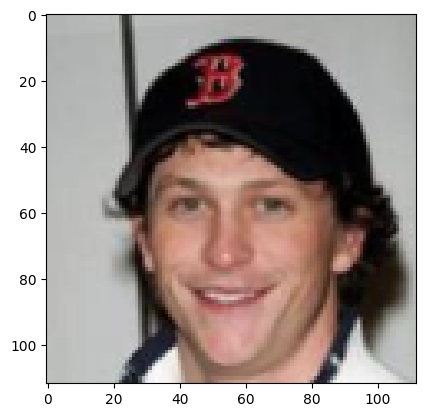

In [10]:
image = next(iter(train_loader))
plt.imshow(image[0].permute(1,2,0))
plt.show()

In [11]:
#model.to(cuda)

#fig, ax = plt.subplots(2)
#torch.no_grad()
#x_train = next(iter(train_loader))
#x_train = x_train.to(cuda)
#outputs, mu, log_var = model(x_train)
#outputs = outputs.cpu().detach()
#ax[0].imshow(x_train.cpu()[0].permute((1,2,0)))
#ax[1].imshow(outputs[0].permute(1,2,0)) 

In [12]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_size = 12544
        self.encoder = nn.Sequential(
            *(list(resnet_half.children())),
            nn.ReLU(),
            nn.Flatten()
        )
        self.mu = nn.Sequential(
            nn.Linear(12544, self.latent_size)
        )
        self.log_var = nn.Sequential(
            nn.Linear(12544, self.latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([256, 7, 7])),
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        x = self.reparameterize(mu, log_var)
        x = self.decoder(x)
        return x, mu, log_var

In [13]:
from collections import OrderedDict

encoder_state_dict = OrderedDict()
encoder = Encoder()
encoder.eval()
for key in model.state_dict().keys():
    if key[0:7] != "decoder":
        encoder_state_dict[key] = model.state_dict()[key]

encoder.load_state_dict(encoder_state_dict)

<All keys matched successfully>

In [14]:
batch = next(iter(train_loader))
output = encoder(batch)
encoder_output = output[0]

In [15]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([256, 7, 7])),
            nn.ConvTranspose2d(256, 256, (3,3),(2,2), padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, (3,3),(2,2)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(2,2)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(2,2)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, (3,3),(1,1), padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, (4,4),(1,1), padding=1),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.decoder(x)
        return x

In [16]:
from collections import OrderedDict

decoder_state_dict = OrderedDict()
decoder = Decoder()
decoder.eval()
for key in model.state_dict().keys():
    if key[0:7] == "decoder":
        decoder_state_dict[key] = model.state_dict()[key]

decoder.load_state_dict(decoder_state_dict)

<All keys matched successfully>

In [182]:
input_size = 12544

a = random.randint(0,len(encoder_output)-1)
b = random.randint(0,len(encoder_output)-1)

start = encoder_output[a].flatten()
end = encoder_output[b].flatten()
#input_seed = torch.randn(input_size)

#variation_dim = random.randint(0,input_size - 1)

In [183]:
n = 20
move_rate = 0.01

input = torch.zeros(n, input_size)
for i in range(1, n):
    torch.zeros(n)
    x = i/n
    input[i] = x*end + (1-x)*start

In [184]:
output = decoder(input).detach().numpy()
output = np.transpose(output, (0, 2, 3, 1))*255
output = output.astype(np.uint8)

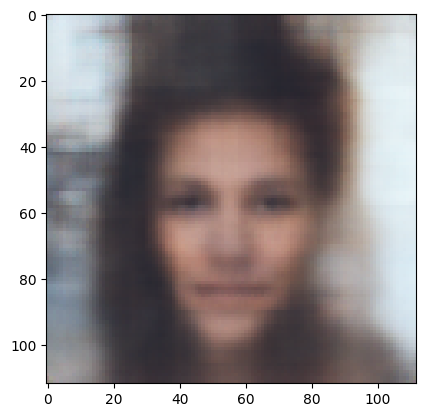

In [185]:
i = random.randint(0,len(input)-1)
plt.imshow(output[i])

In [186]:
imageio.mimwrite("output3.gif", output, 'GIF', loop=100)

In [187]:
latent_1 = encoder_output.detach().numpy()[:,0,1,0]
latent_2 = encoder_output.detach().numpy()[:,1,0,0]


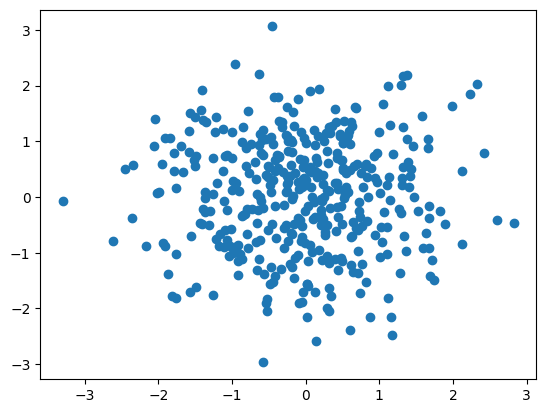

In [188]:
plt.scatter(latent_1, latent_2)

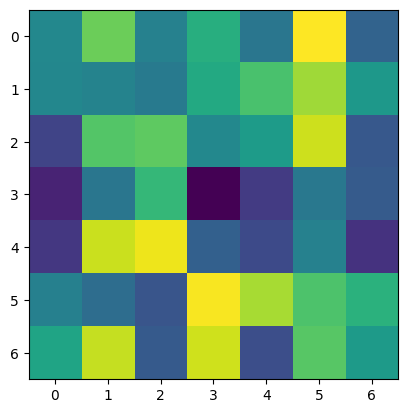

In [189]:
plt.imshow(encoder_output[0][4].detach().numpy())